# UMAP and T-SNE with K-means and DBSCAN

In [101]:
# Denoising
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from scipy.signal import stft
from scipy.signal import find_peaks
from collections import defaultdict
from scipy.ndimage import median_filter, gaussian_filter
from skimage import measure
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [2]:
# List of shot IDs
shot_ids = [23447, 30005, 30021, 30421]  # Add more as needed

# S3 endpoint
endpoint = "https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

In [3]:
store_list = []
zgroup_list = []

# Loop through each shot ID
for shot_id in shot_ids:
    path = Path(f"shots/{shot_id}.zarr")

    if not path.exists():
        print(f"Local path {path} not found.")
        continue

    store = zarr.DirectoryStore(str(path))
    store_list.append(store)

    try:
        zgroup = zarr.open(store, mode='r')
        zgroup_list.append(zgroup)
        print(f"Loaded shot ID {shot_id}")
        # Example: print available array keys
        # print(list(zgroup.array_keys()))
    except Exception as e:
        print(f"Failed to load shot ID {shot_id}: {e}")

Loaded shot ID 23447
Loaded shot ID 30005
Loaded shot ID 30021
Loaded shot ID 30421


In [4]:
# DOWNLOAD FROM S3 BUCKET
# store_list = []
# zgroup_list = []

# # Loop through each shot ID
# for shot_id in shot_ids:
#     url = f"s3://mast/level2/shots/{shot_id}.zarr"
    
#     store = zarr.storage.FSStore(fs=fs, url=url)
#     store_list.append(store)
#     # open or download the Zarr group
#     try:
#         zgroup_list.append(zarr.open(store, mode='r'))
#         print(f"Loaded shot ID {shot_id}")
#         # Do something with zgroup here, like listing arrays:
#         # print(list(zgroup.array_keys()))
#     except Exception as e:
#         print(f"Failed to load shot ID {shot_id}: {e}")

In [5]:
mirnov = [xr.open_zarr(store, group="magnetics") for store in store_list]
ds_list = [m['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1) for m in mirnov]

In [7]:
def plot_stft_spectrogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    tmin=0.1,    tmax=0.46,    fmax_kHz=50,    cmap='jet'):
    """
    Plot STFT spectrogram for a given xarray DataArray `ds`.
    
    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - tmin, tmax: Time range to display (seconds).
    - fmax_kHz: Max frequency to display (kHz).
    - cmap: Colormap name.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    #ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"STFT Spectrogram"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()
#[plot_stft_spectrogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]

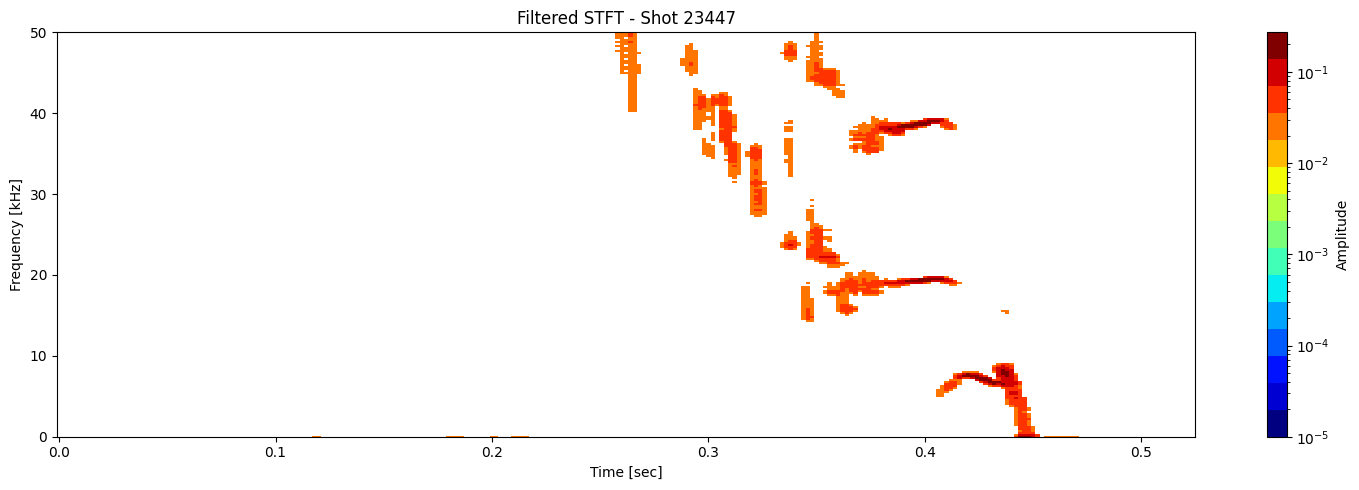

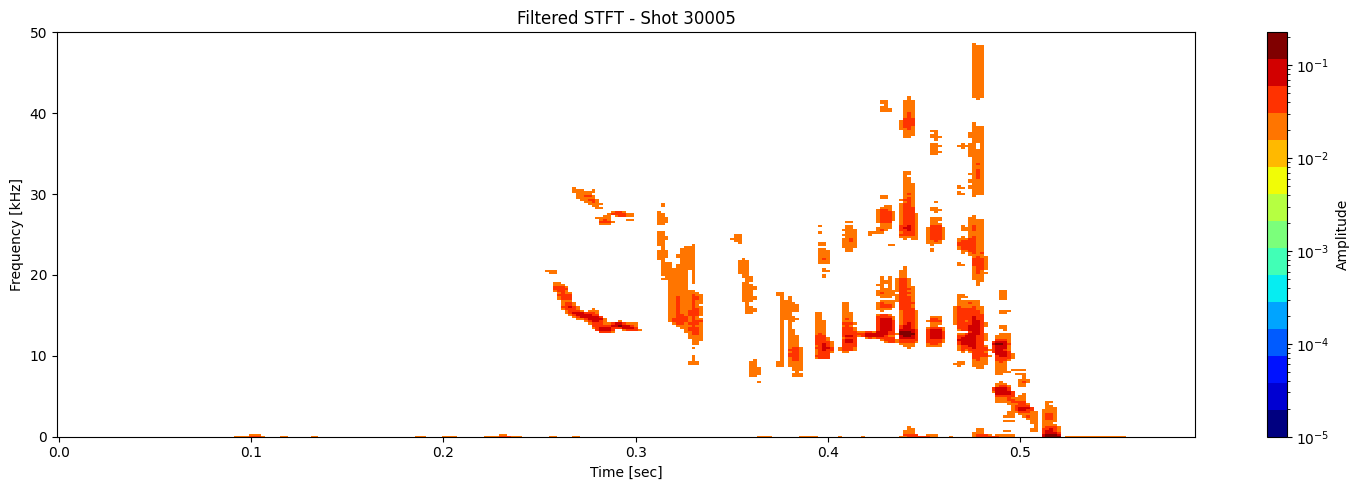

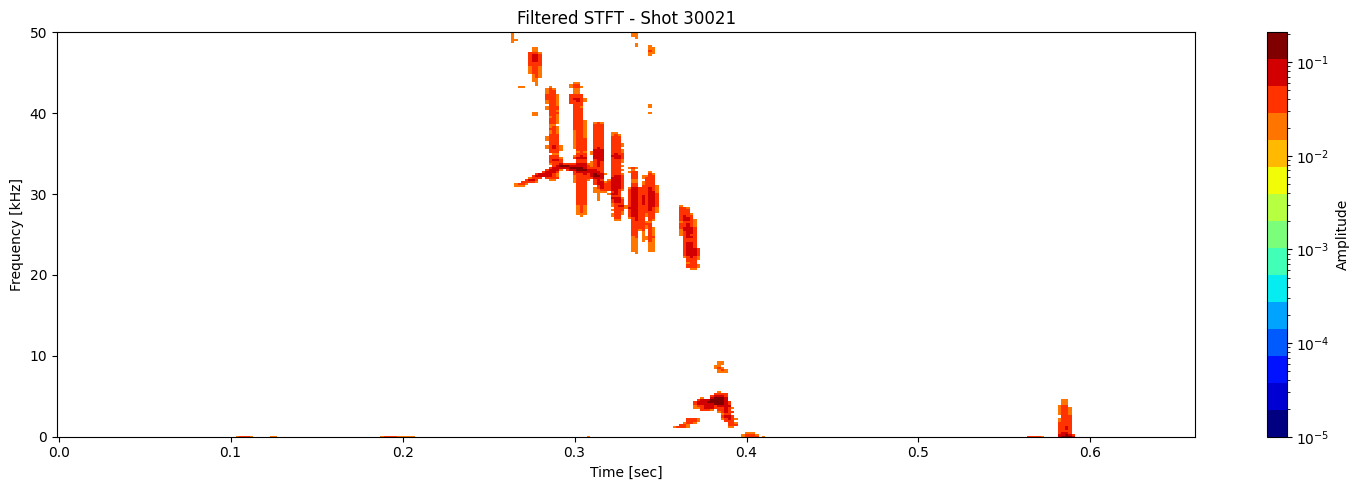

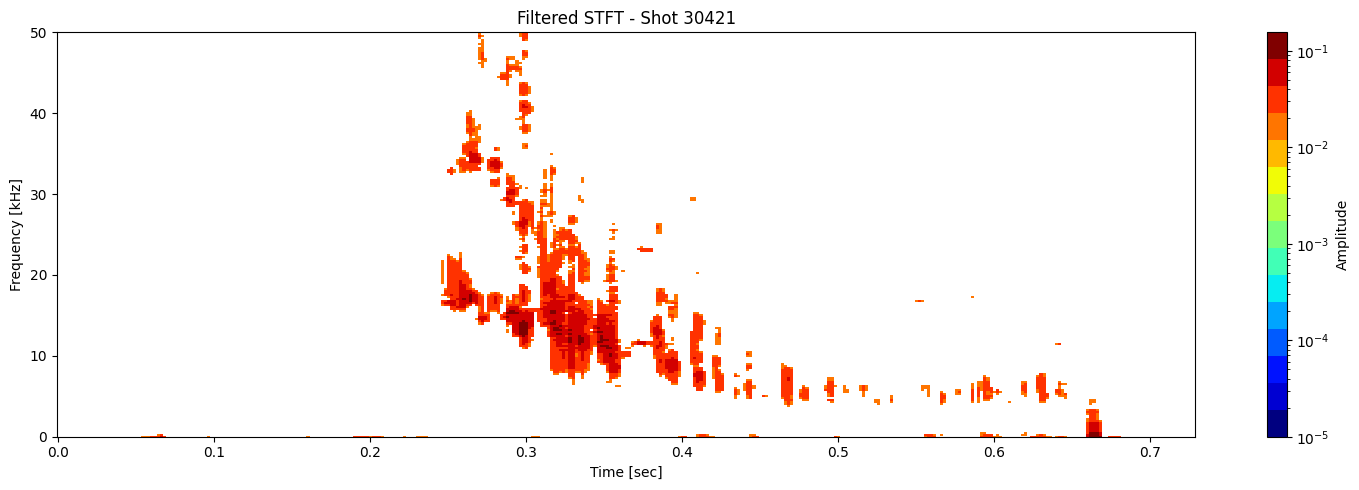

In [8]:
def plot_amplitude_masking(ds, shot_id=None, nperseg=2000, nfft=2000,
                           sigma=1.0, apply_gaussian=False, apply_mask=True,
                           mask_percentile=60, use_percentage=True,
                           tmin=0.1, tmax=0.46, fmax_kHz=50, cmap='jet', apply_savgol_filter = False):
    """
    Plots the STFT spectrogram with optional Gaussian blur and masking. This is one function doing everything. No helper needed.

    Parameters:
    - ds: xarray.DataArray with 'time_mirnov'
    - shot_id: Optional shot ID
    - apply_gaussian: Whether to apply Gaussian blur
    - apply_mask: Whether to apply masking
    - mask_percentile: If use_percentage=True, keep top X% of points.
                       Else, mask values below the Xth percentile.
    - use_percentage: Use percentage thresholding instead of percentile
    """

    # Compute STFT
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)
    magnitude = np.abs(Zxx)  # Take magnitude of complex STFT

    # Optional Gaussian blur (for smoothing the spectrogram)
    if apply_gaussian:
        magnitude = gaussian_filter(magnitude, sigma=sigma)

    # savgol filter
    if apply_savgol_filter:
        # windows length Must be an odd integer.
        # 
        window_length = max(5, min(11, len(f) // 3 * 2 + 1))
        magnitude = savgol_filter(magnitude, window_length=7, polyorder=2)

    # Clip negative values just in case blur introduced due to skewed data like sharp gradients
    magnitude = np.clip(magnitude, 0, None)

    # Apply masking
    if apply_mask:
        if use_percentage:
            # Flatten and sort finite values to find cutoff for top X% values
            valid = magnitude[np.isfinite(magnitude)].flatten()
            if valid.size > 0:
                sorted_vals = np.sort(valid)
                cut_index = int((1 - mask_percentile / 100) * len(sorted_vals))
                cutoff_value = sorted_vals[cut_index]
                # Mask all values below cutoff
                magnitude = np.where(magnitude >= cutoff_value, magnitude, np.nan)
        else:
            # Use standard percentile-based thresholding
            threshold = np.percentile(magnitude, mask_percentile)
            magnitude = np.where(magnitude >= threshold, magnitude, np.nan)

    # save a copy of the segmented spectrogram
    segmented_stft = magnitude.copy()


    # Skip if everything got masked (to avoid plotting empty images)
    if not np.any(np.isfinite(magnitude)):
        print(f"Shot {shot_id} — all values masked. Skipping plot.")
        return

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, magnitude,
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    #ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"Filtered STFT - Shot {shot_id}" if shot_id else "Filtered STFT"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

    return t, f, segmented_stft, Zxx
results = [plot_amplitude_masking(ds_list[i], shot_ids[i], mask_percentile=1, sigma=0.9, apply_gaussian=False, apply_savgol_filter=True) for i in range(len(ds_list))]
t_list, f_list, seg_list, Zxx_list = zip(*results)

## contour

In [10]:
def plot_spectrogram_with_contours(Zxx, f, t, contours, shot_id=None, vmin=1e-5):

    f_kHz = f / 1000

    fig, ax = plt.subplots(figsize=(12, 5))
    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    for contour in contours:
        ax.plot(t[np.clip(contour[:, 1].astype(int), 0, len(t) - 1)],
                f_kHz[np.clip(contour[:, 0].astype(int), 0, len(f) - 1)],
                color='black', lw=0.5)


    ax.set_ylim(0, 70)
    #ax.set_xlim(0.1, 0.46)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [kHz]')
    title = "STFT with Contour Overlay"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    plt.grid(True)
    plt.tight_layout()

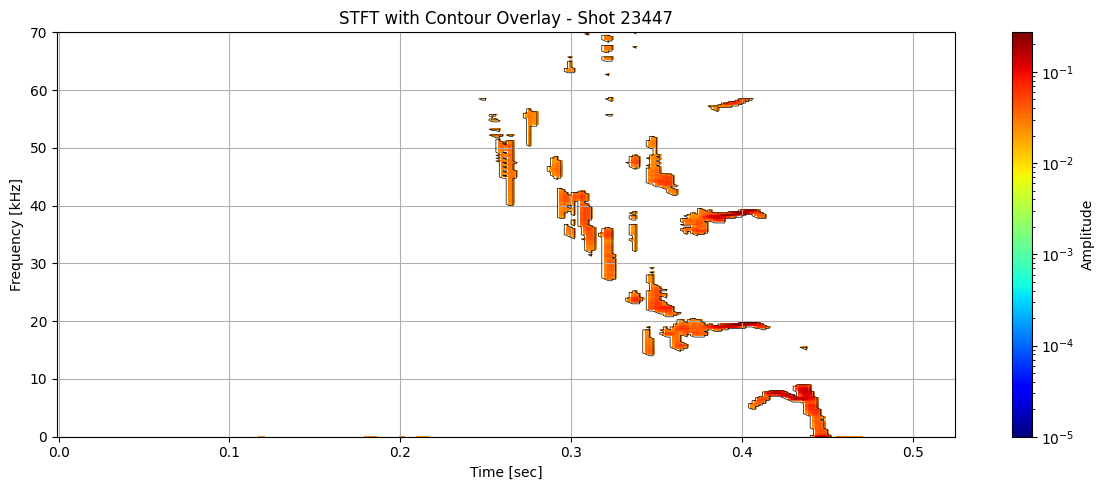

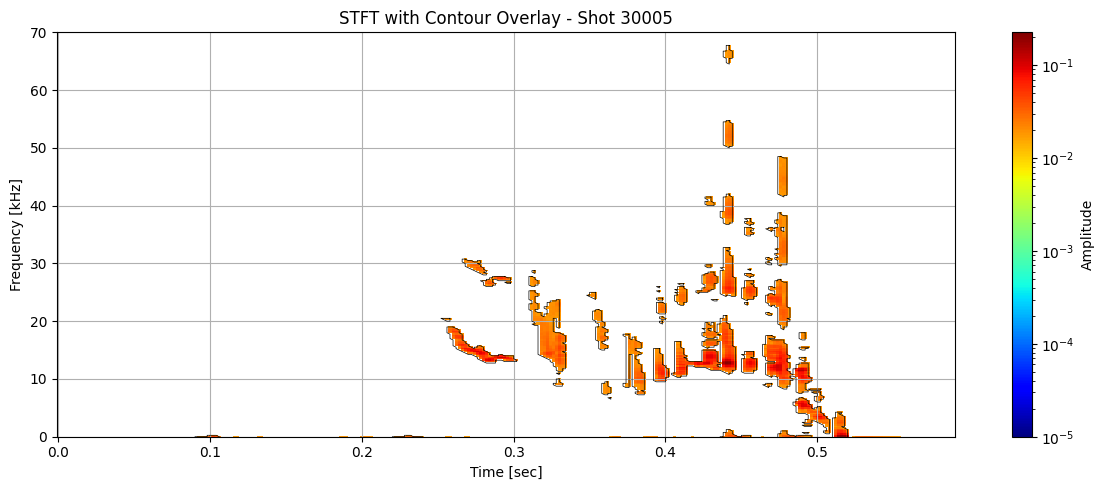

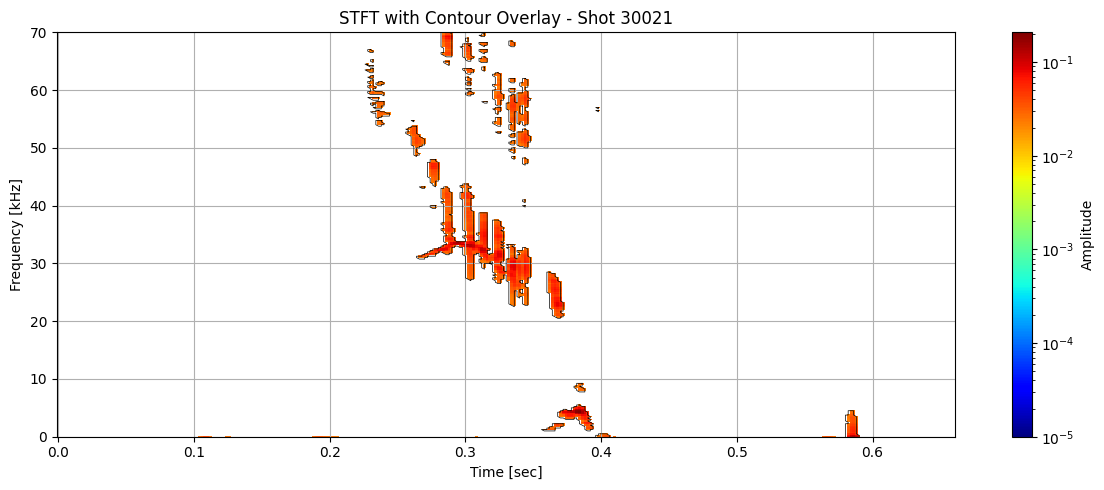

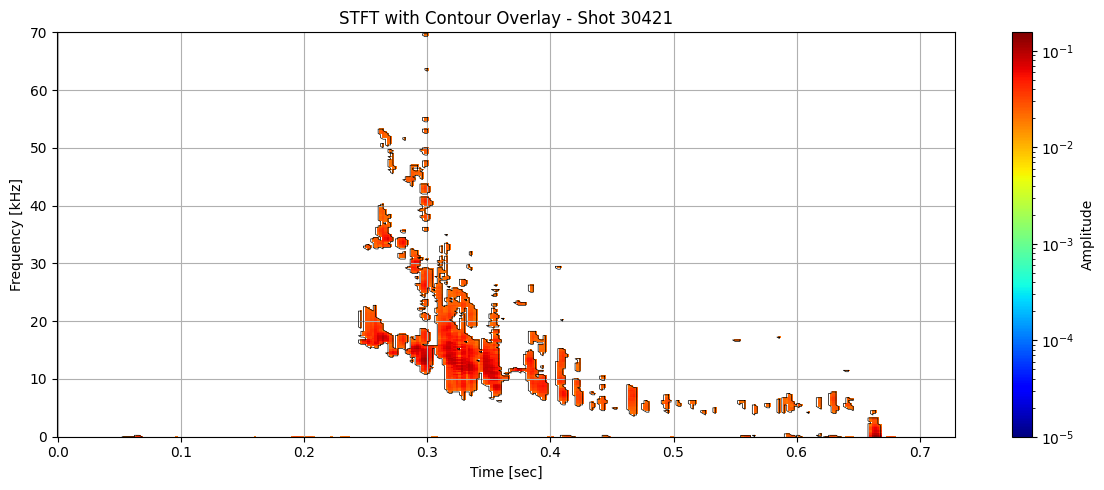

In [11]:
for i in range(len(ds_list)):
    # Use masked STFT (seg_list[i]) to extract binary mask
    binary_mask = np.isfinite(seg_list[i]).astype(float)
    # Get contours at 0.5 (standard threshold for binary masks)
    contours = measure.find_contours(binary_mask, level=0.5)
    plot_spectrogram_with_contours(seg_list[i], f_list[i], t_list[i], contours, shot_id=shot_ids[i])


In [12]:
def extract_contour_features(contour, t, f, Zxx):
    """Extract features from a single contour."""
    time_idx = np.clip(contour[:, 1].astype(int), 0, len(t) - 1)
    freq_idx = np.clip(contour[:, 0].astype(int), 0, len(f) - 1)
    
    times = t[time_idx]
    freqs = f[freq_idx]# / 1000  # in kHz
    amps = np.abs(Zxx[freq_idx, time_idx])
    
    # Handle degenerate contours
    if len(times) < 2:
        return None
    
    # Features
    duration = times.max() - times.min()
    freq_span = freqs.max() - freqs.min()
    slope = np.polyfit(times, freqs, 1)[0]
    avg_amp = np.mean(amps)
    max_amp = np.max(amps)
    
    return {
        'duration': duration,
        'freq_span': freq_span,
        'slope': slope,
        'avg_amp': avg_amp,
        'max_amp': max_amp,
        'start_time': times.min(),
        'end_time': times.max(),
        'start_freq': freqs[0],
        'end_freq': freqs[-1],
        'length': len(times),
    }


In [13]:
# Initialize a list to collect all feature DataFrames
all_feature_dfs = []
# Extract features from all contours
# Loop through each shot to extract contour features
for i in range(len(ds_list)):
    #  Binary mask from segmented STFT (NaNs were introduced during masking)
    binary_mask = np.isfinite(seg_list[i]).astype(float)

    #  Detect contours at 0.5 level (standard threshold for binary masks)
    contours = measure.find_contours(binary_mask, level=0.5)

    # #  Extract features for each contour using helper
    # features = [extract_contour_features(c, t_list[i], f_list[i], Zxx_list[i]) for c in contours]

    # #  Filter out any invalid results (None entries)
    # features = [f for f in features if f is not None]

    # for f in features:
    #     f['shot_id'] = shot_ids[i]  # Add shot ID to each feature dict
    
    features = []
    for j, c in enumerate(contours):  # add j for contour index
        feat = extract_contour_features(c, t_list[i], f_list[i], Zxx_list[i])
        if feat is not None:
            feat['shot_id'] = shot_ids[i]
            feat['contour_idx'] = j       
            features.append(feat)

    all_feature_dfs.extend(features)

# Concatenate into a single DataFrame
df_all = pd.DataFrame(all_feature_dfs)

In [14]:
df_all.head()

duration  freq_span         slope   avg_amp   max_amp  start_time  \
0     0.004      0.000      0.000000  0.023028  0.024961    0.116000   
1     0.008      0.000      0.000000  0.025997  0.033559    0.178000   
2     0.004      0.000      0.000000  0.021432  0.024144    0.198000   
3     0.008      0.000      0.000000  0.021969  0.025508    0.208000   
4     0.048   8999.982 -85343.955436  0.012600  0.110189    0.404001   

   end_time  start_freq  end_freq  length  shot_id  contour_idx  
0  0.120000         0.0       0.0       4    23447            0  
1  0.186000         0.0       0.0       6    23447            1  
2  0.202000         0.0       0.0       4    23447            2  
3  0.216000         0.0       0.0       6    23447            3  
4  0.452001         0.0       0.0     148    23447            4

In [15]:
df_clean = df_all.dropna()

###### More filtering needed. A lot of garbage contour still left #######
df_clean = df_clean[(df_clean['duration'] > 0.004) & 
                    (df_clean['avg_amp'] > 1e-4) &
                    (df_clean['length'] >= 5)&
                    (df_clean['freq_span'] > 0.1) &
                    (np.abs(df_clean['slope']) < 5e4)]

# select all rows with shot_id 23447
df_clean[df_clean['shot_id'] == 23447].head()

duration  freq_span         slope   avg_amp   max_amp  start_time  \
7      0.064  5749.9885  30710.906079  0.023135  0.156930    0.352001   
8      0.004   499.9990 -23026.223684  0.030197  0.046078    0.434001   
11     0.010  2249.9955  -5161.559246  0.013658  0.051164    0.332001   
19     0.050  4749.9905  43065.864199  0.021728  0.149185    0.364001   
21     0.004   749.9985   4166.650000  0.031503  0.057582    0.334001   

    end_time  start_freq    end_freq  length  shot_id  contour_idx  
7   0.416001  20499.9590  20499.9590     145    23447            7  
8   0.438001  15499.9690  15499.9690       9    23447            8  
11  0.342001  25249.9495  25249.9495      29    23447           11  
19  0.414001  39499.9210  39499.9210     121    23447           19  
21  0.338001  38249.9235  38249.9235      11    23447           21

In [16]:
len(df_clean)

261

In [17]:
features_for_pca = df_clean[[
    'duration',
    'freq_span',
    'slope',
    'avg_amp',
    'max_amp',
    'length',
    'start_time',
    'end_time',
    'start_freq',
    'end_freq'
    # add 'start_time', 'end_time', etc. if you want temporal position in clustering
]]

# UMAP

/home/hell/Desktop/lightning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hell/Desktop/lightning/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


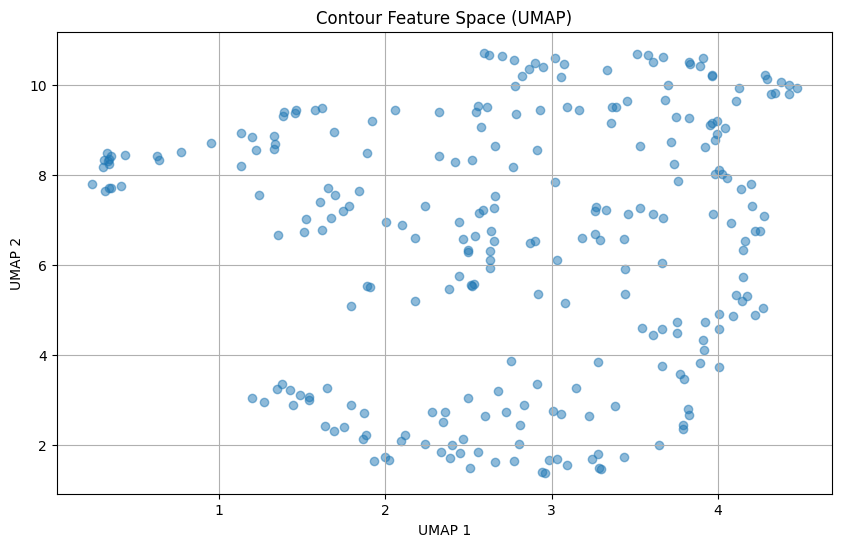

In [82]:


# Use the same scaled features
X_scaled = StandardScaler().fit_transform(features_for_pca)

# UMAP projection to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Contour Feature Space (UMAP)")
plt.grid(True)

In [83]:
n_clusters = 5
kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42).fit(X_umap)
df_clean['cluster_umap'] = kmeans_umap.labels_
cluster_labels = kmeans_umap.labels_



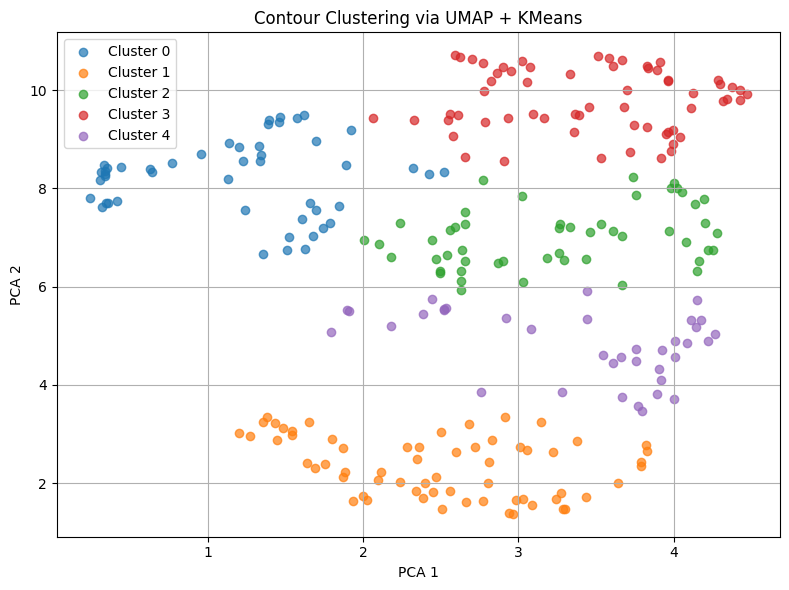

In [84]:
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    mask = cluster_labels == i
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=f"Cluster {i}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Contour Clustering via UMAP + KMeans")
plt.legend()
plt.grid(True)
plt.tight_layout()

/tmp/ipykernel_13313/2079072207.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_clusters)


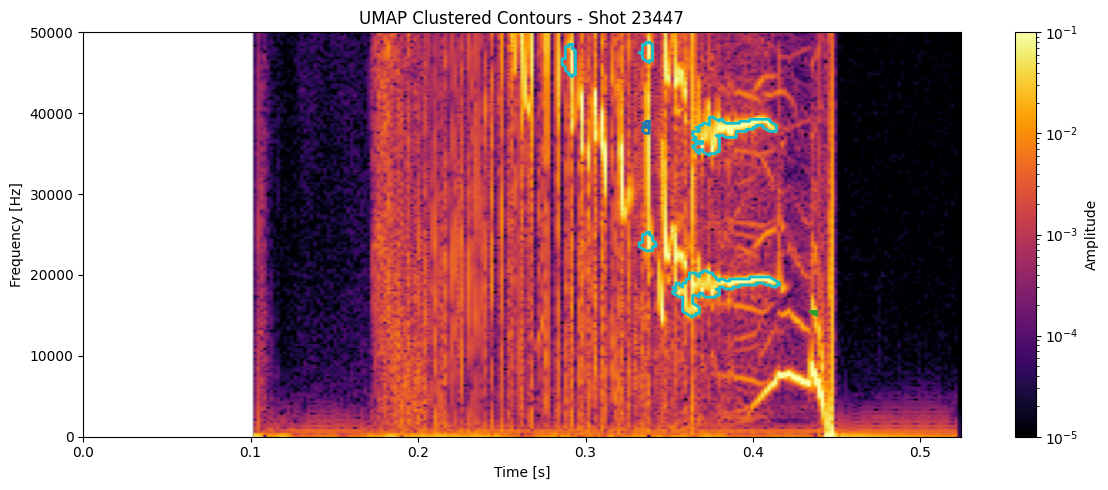

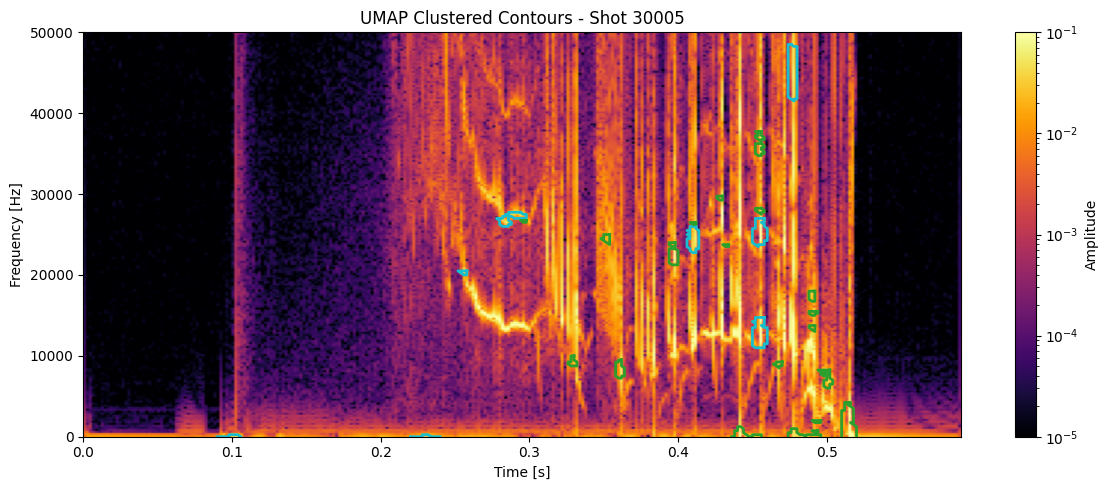

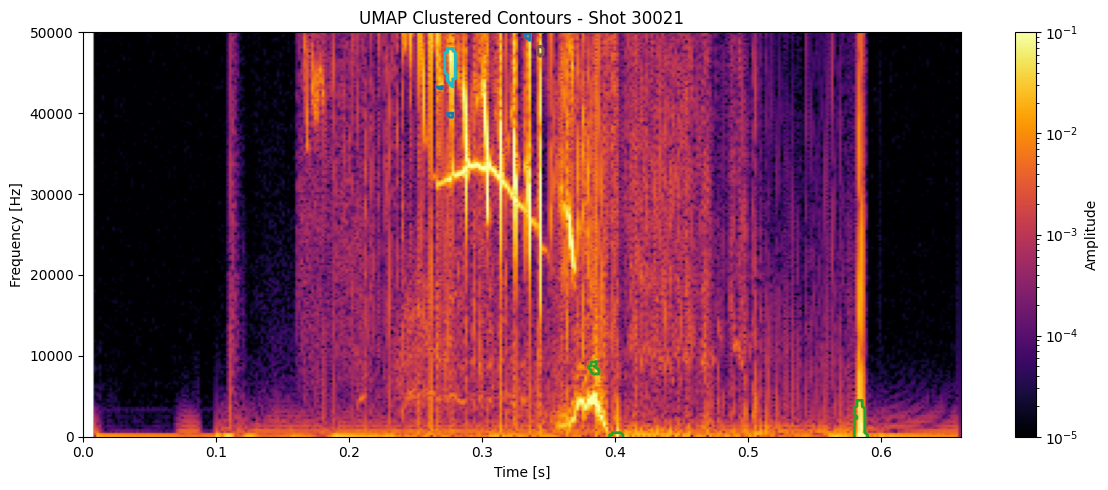

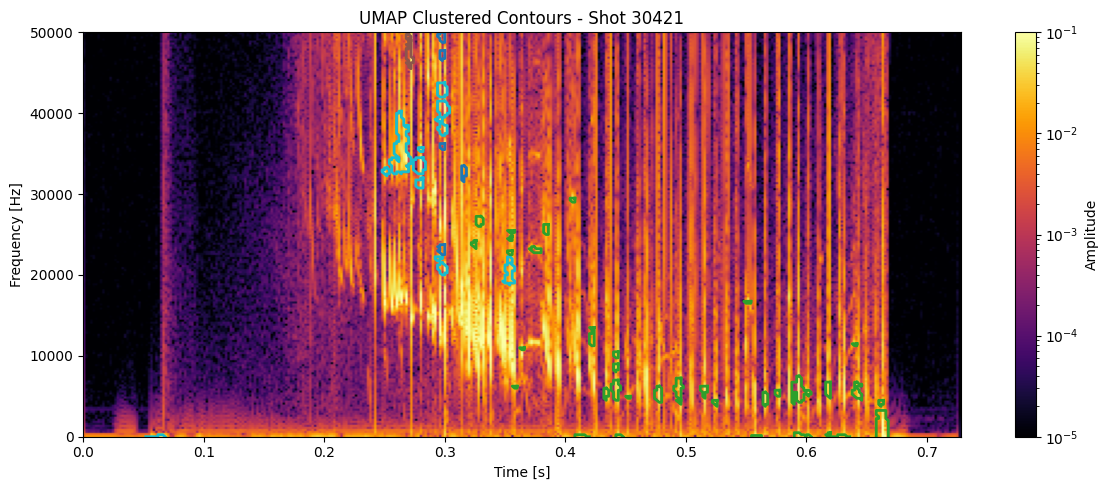

In [85]:
#df_clean['cluster'] = cluster_labels
num_clusters = df_clean['cluster_umap'].nunique()
colors = cm.get_cmap('tab10', num_clusters)

for shot_id in df_clean['shot_id'].unique():
    # Pull the STFT and metadata for this shot
    idx = shot_ids.index(shot_id)
    #Z = ds_list[idx]
    Z = np.abs(Zxx_list[idx]) 
    t = t_list[idx]
    f = f_list[idx]

    # Get contours and cluster labels for this shot
    df_shot = df_clean[df_clean['shot_id'] == shot_id]
    contours = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)

    plt.figure(figsize=(12, 5))
    plt.imshow(
        np.abs(Zxx_list[idx]),
        aspect='auto', origin='lower',
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap='inferno', norm=LogNorm(vmin=1e-5, vmax=1e-1)
    )
    # for _, row in df_shot.iterrows():
    #     # Reconstruct a line segment if you still have contours
    #     #c = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)[int(row.name)]
    #     c = contours[int(row['contour_idx'])] 
    #     plt.plot(t[c[:, 1].astype(int)], f[c[:, 0].astype(int)], 
    #              color=colors(row['cluster']), linewidth=2)

    for _, row in df_shot.iterrows():
        contour = contours[int(row['contour_idx'])]     # this links to clustering
        t_pts = t[contour[:, 1].astype(int)]
        f_pts = f[contour[:, 0].astype(int)]
        plt.plot(t_pts, f_pts, color=colors(int(row['cluster_umap'])), linewidth=2)

    plt.colorbar(label='Amplitude')
    plt.title(f"UMAP Clustered Contours - Shot {shot_id}")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, 50000)
    plt.tight_layout()
    plt.show()


# tSNE (t-distributed Stochastic Neighbor Embedding)

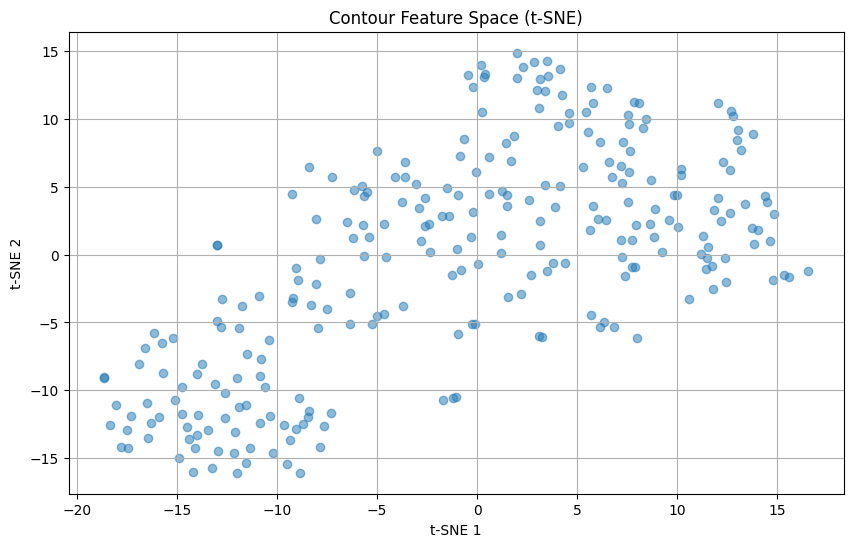

In [86]:
# Same X_scaled as before
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Contour Feature Space (t-SNE)")
plt.grid(True)


In [93]:
n_clusters = 5
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(X_tsne)
cluster_labels = kmeans_tsne.labels_
df_clean['cluster_tsne'] = cluster_labels


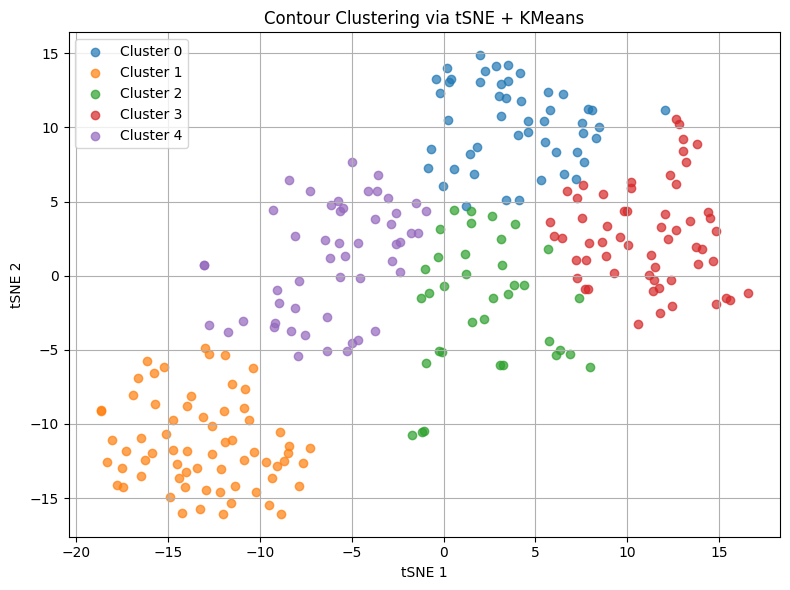

In [94]:
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    mask = cluster_labels == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=f"Cluster {i}", alpha=0.7)

plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title("Contour Clustering via tSNE + KMeans")
plt.legend()
plt.grid(True)
plt.tight_layout()

/tmp/ipykernel_13313/1734226472.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_clusters)


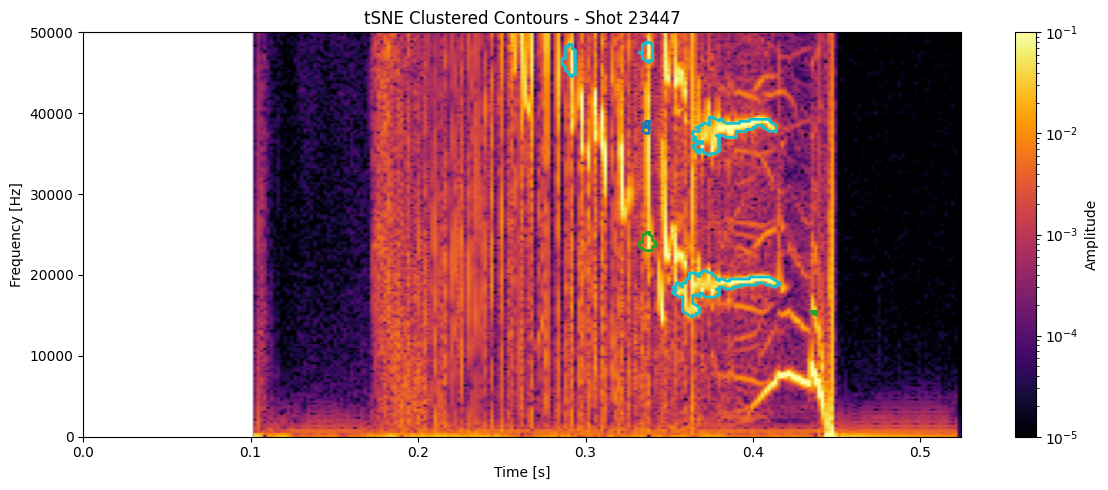

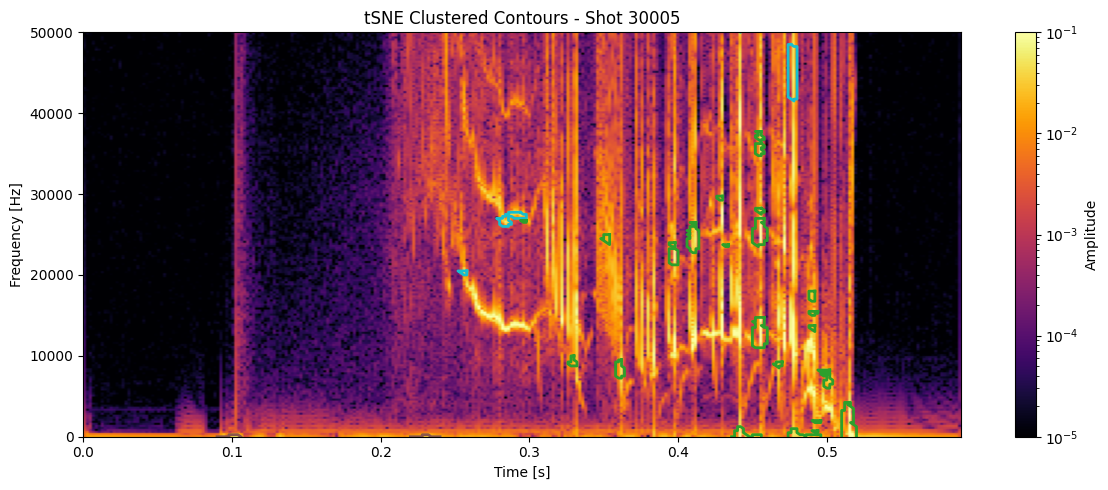

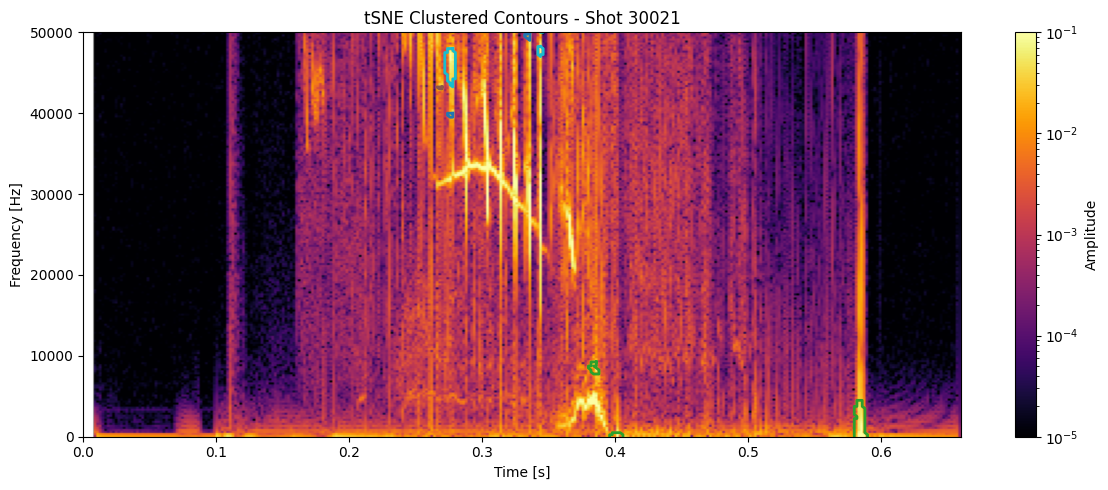

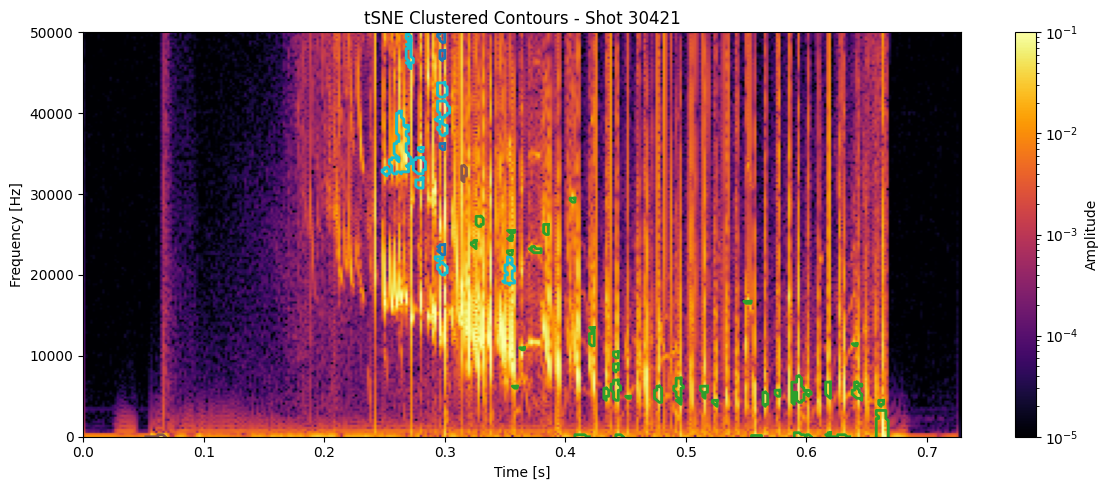

In [95]:
#df_clean['cluster'] = cluster_labels
num_clusters = df_clean['cluster_tsne'].nunique()
colors = cm.get_cmap('tab10', num_clusters)

for shot_id in df_clean['shot_id'].unique():
    # Pull the STFT and metadata for this shot
    idx = shot_ids.index(shot_id)
    #Z = ds_list[idx]
    Z = np.abs(Zxx_list[idx]) 
    t = t_list[idx]
    f = f_list[idx]

    # Get contours and cluster labels for this shot
    df_shot = df_clean[df_clean['shot_id'] == shot_id]
    contours = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)

    plt.figure(figsize=(12, 5))
    plt.imshow(
        np.abs(Zxx_list[idx]),
        aspect='auto', origin='lower',
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap='inferno', norm=LogNorm(vmin=1e-5, vmax=1e-1)
    )
    # for _, row in df_shot.iterrows():
    #     # Reconstruct a line segment if you still have contours
    #     #c = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)[int(row.name)]
    #     c = contours[int(row['contour_idx'])] 
    #     plt.plot(t[c[:, 1].astype(int)], f[c[:, 0].astype(int)], 
    #              color=colors(row['cluster']), linewidth=2)

    for _, row in df_shot.iterrows():
        contour = contours[int(row['contour_idx'])]     # this links to clustering
        t_pts = t[contour[:, 1].astype(int)]
        f_pts = f[contour[:, 0].astype(int)]
        plt.plot(t_pts, f_pts, color=colors(int(row['cluster_tsne'])), linewidth=2)

    plt.colorbar(label='Amplitude')
    plt.title(f"tSNE Clustered Contours - Shot {shot_id}")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, 50000)
    plt.tight_layout()
    plt.show()


# DBSCAN (Density-Based Spatial Clustering of Applications with Noise) using UMAP

In [96]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  # ← tune these later
cluster_labels_dbscan = dbscan.fit_predict(X_umap)  # or X_tsne

df_clean['cluster_dbscan'] = cluster_labels_dbscan
unique, counts = np.unique(cluster_labels_dbscan, return_counts=True)
print("DBSCAN clusters:", dict(zip(unique, counts)))

DBSCAN clusters: {np.int64(-1): np.int64(3), np.int64(0): np.int64(23), np.int64(1): np.int64(63), np.int64(2): np.int64(172)}


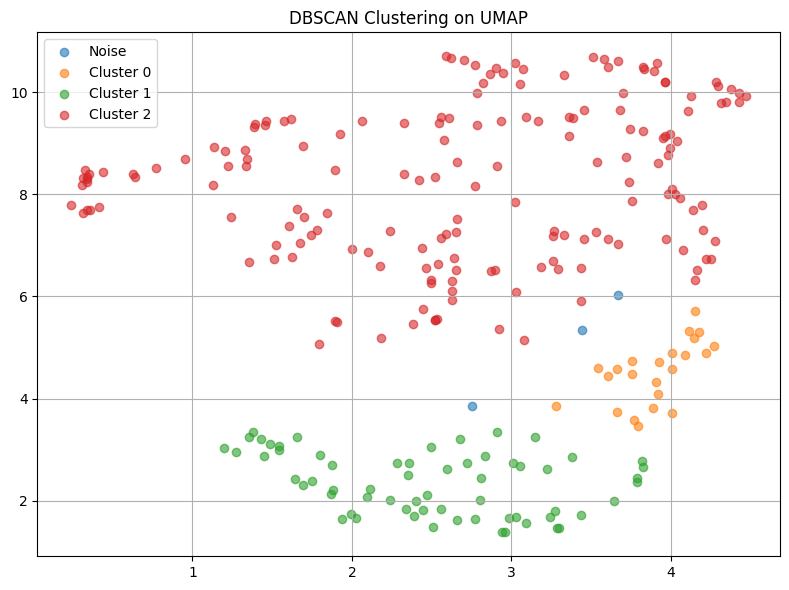

In [97]:
plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels_dbscan):
    mask = cluster_labels_dbscan == label
    label_str = "Noise" if label == -1 else f"Cluster {label}"
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=label_str, alpha=0.6)

plt.title("DBSCAN Clustering on UMAP")
plt.legend()
plt.grid(True)
plt.tight_layout()


/tmp/ipykernel_13313/3755825970.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_clusters)


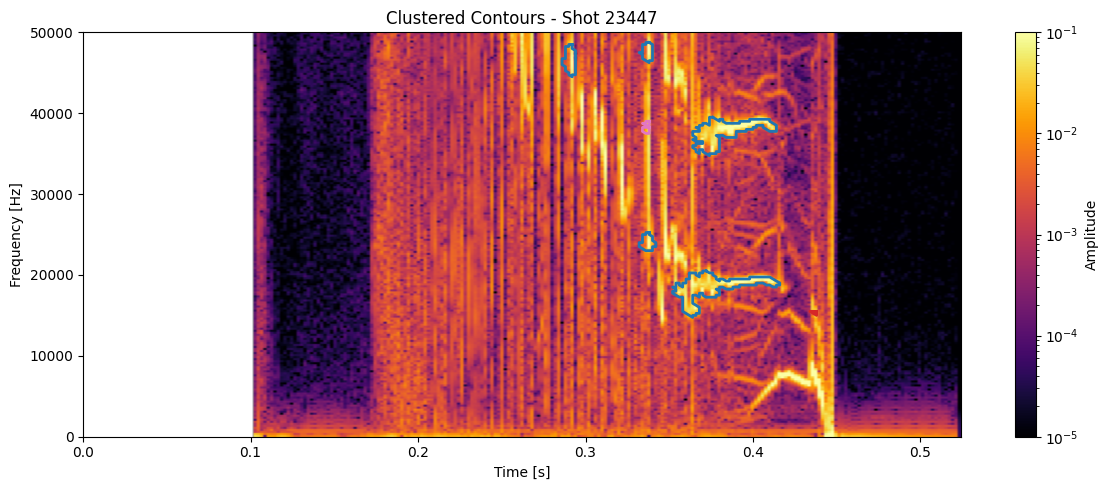

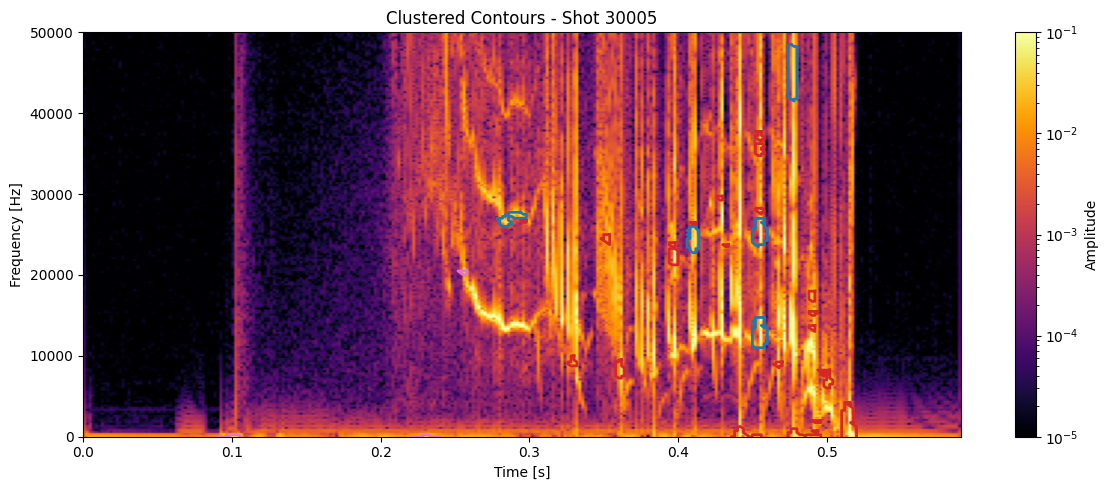

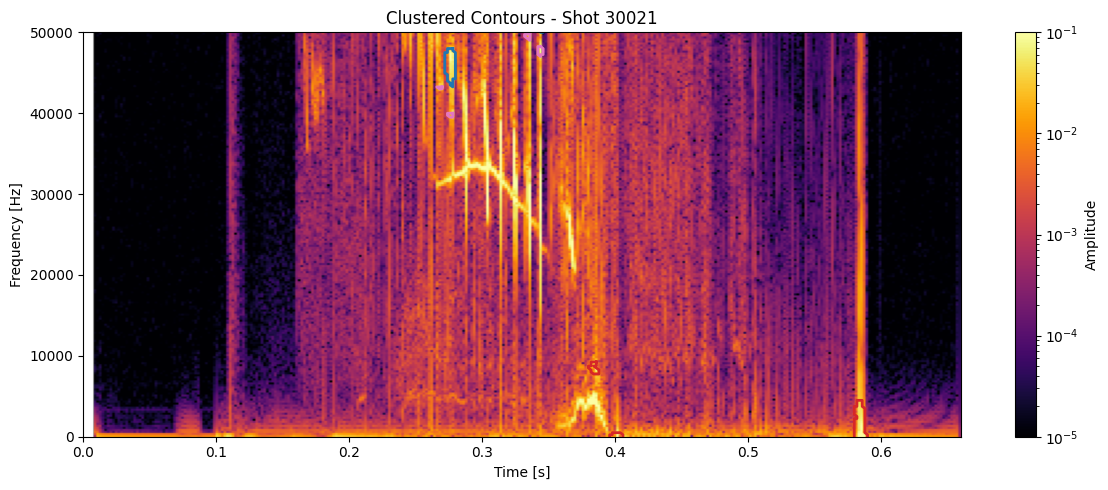

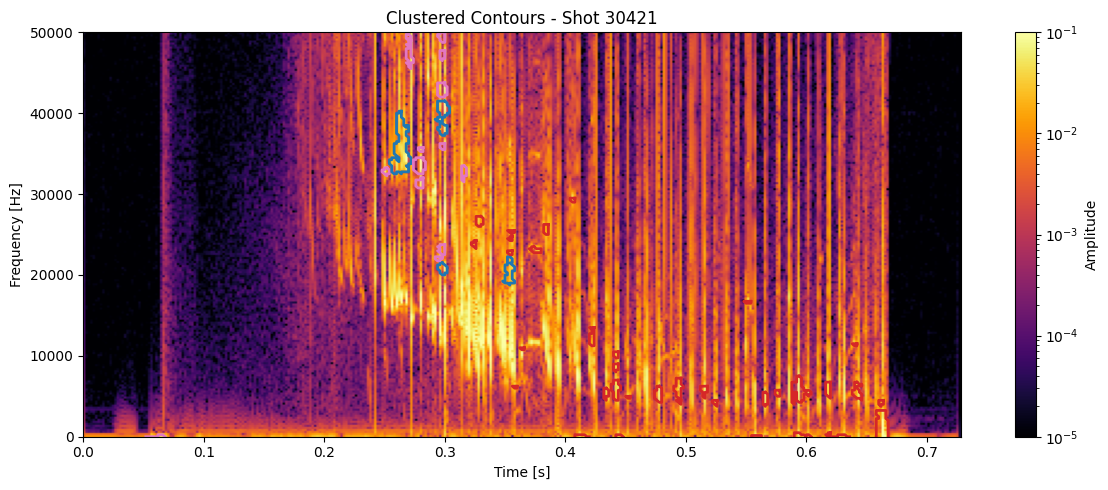

In [99]:
num_clusters = df_clean['cluster_dbscan'].nunique()
colors = cm.get_cmap('tab10', num_clusters)

for shot_id in df_clean['shot_id'].unique():
    # Pull the STFT and metadata for this shot
    idx = shot_ids.index(shot_id)
    #Z = ds_list[idx]
    Z = np.abs(Zxx_list[idx]) 
    t = t_list[idx]
    f = f_list[idx]

    # Get contours and cluster labels for this shot
    df_shot = df_clean[df_clean['shot_id'] == shot_id]
    contours = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)

    plt.figure(figsize=(12, 5))
    plt.imshow(
        np.abs(Zxx_list[idx]),
        aspect='auto', origin='lower',
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap='inferno', norm=LogNorm(vmin=1e-5, vmax=1e-1)
    )
    # for _, row in df_shot.iterrows():
    #     # Reconstruct a line segment if you still have contours
    #     #c = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)[int(row.name)]
    #     c = contours[int(row['contour_idx'])] 
    #     plt.plot(t[c[:, 1].astype(int)], f[c[:, 0].astype(int)], 
    #              color=colors(row['cluster']), linewidth=2)

    for _, row in df_shot.iterrows():
        contour = contours[int(row['contour_idx'])]     # this links to clustering
        t_pts = t[contour[:, 1].astype(int)]
        f_pts = f[contour[:, 0].astype(int)]
        plt.plot(t_pts, f_pts, color=colors(int(row['cluster_dbscan'])), linewidth=2)

    plt.colorbar(label='Amplitude')
    plt.title(f"Clustered Contours - Shot {shot_id}")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, 50000)
    plt.tight_layout()
    plt.show()

In [104]:
"""
The Adjusted Rand Index is a statistical measure of the similarity between two clusterings, correcting for chance. 1 is a perfect match, 0 is random clustering.
"""
print("UMAP KMEANS vs tSNE KMEANS:", adjusted_rand_score(df_clean['cluster_umap'], df_clean['cluster_tsne']))
print("UMAP KMEANS vs UMAP DBSCAN:", adjusted_rand_score(df_clean['cluster_umap'], df_clean['cluster_dbscan']))

UMAP KMEANS vs tSNE KMEANS: 0.6211465074985093
UMAP KMEANS vs UMAP DBSCAN: 0.3626358763159303
